In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def show_images_mxn(images, m, n):
    #images = np.reshape(images, [m, n, -1])
    sqrtimg = int(np.ceil(np.sqrt(images.shape[2])))

    fig = plt.figure(figsize=(m, n))
    gs = gridspec.GridSpec(m, n)
    gs.update(wspace=0.05, hspace=0.05)

    for i in range(m):
        for j in range(n):
            img = images[i,j]
            ax = plt.subplot(gs[i*n+j])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    plt.savefig('plots/transformations.png')

Extracting ./datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
49


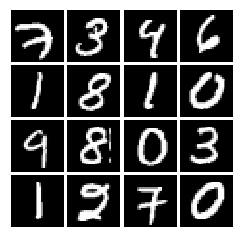

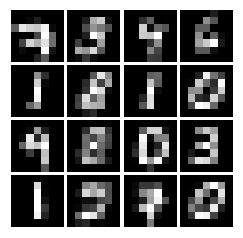

In [28]:
def pool(X, pool_size=4, pool_type="max"):
    # stride == pool_size and pool_size should divide L
    stride = pool_size
    N, D = np.shape(X)
    L = int(np.ceil(np.sqrt(D)))
    X_imgs = X.reshape(N, L, L)
    L1 = int(L/pool_size)
    X1 = np.zeros((N, L1, L1))
    for i in range(L1):
        for j in range(L1):
            if pool_type == "max":
                X1[:,i,j] = np.max(X_imgs[:,i*stride:i*stride+pool_size, j*stride:j*stride+pool_size], axis=(1,2))
            elif pool_type == "avg":
                X1[:,i,j] = np.mean(X_imgs[:,i*stride:i*stride+pool_size, j*stride:j*stride+pool_size], axis=(1,2))
            elif pool_type == "median":
                X1[:,i,j] = np.median(X_imgs[:,i*stride:i*stride+pool_size, j*stride:j*stride+pool_size], axis=(1,2))
    return np.reshape(X1, (N,-1))

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./datasets/MNIST_data', one_hot=False)
X_train = pool(mnist.train.images, 4, "avg")
#X_train = mnist.train.images
y_train = mnist.train.labels
X_test = pool(mnist.test.images, 4, "avg")
#X_test = mnist.test.images
y_test = mnist.test.labels

X_val = pool(mnist.validation.images, 4, "avg")
#X_val = mnist.validation.images
y_val = mnist.validation.labels

N, D = np.shape(X_train)

print(D)

# show a batch
show_images(mnist.train.images[0:16])
show_images(X_train[0:16])

In [3]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

In [43]:
# clear old variables
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, D])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# Number of hidden neurons
H1 = 16
H2 = 9
def deeper_model(X):
    W1 = weight_variable([D,H1], "h1_weights")
    b1 = bias_variable([H1], "h1_biases")
    W2 = weight_variable([H1,H2], "h2_weights")
    b2 = bias_variable([H2], "h2_biases")
    W3 = weight_variable([H2,10], "out_weights")
    b3 = bias_variable([10], "out_biases")
    h1_out = tf.nn.tanh(tf.matmul(X, W1) + b1)
    h2_out = tf.nn.sigmoid(tf.matmul(h1_out, W2) + b2)
    y_out = tf.matmul(h2_out, W3) + b3
    return y_out

y_out = deeper_model(X)

regularization_strength = 0.001
trainable_vars   = tf.trainable_variables()
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in trainable_vars if 'bias' not in v.name ])

mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
mean_loss += lossL2*regularization_strength
train_step = tf.train.AdamOptimizer().minimize(mean_loss)

In [44]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    training_epoch_loss = []
    training_epoch_accuracy = []
    cv_epoch_loss = []
    cv_epoch_accuracy = []
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        
        if training is not None: 
            training_epoch_loss.append(total_loss)
            training_epoch_accuracy.append(total_correct)
            print("cross-validation")
            cv_loss, cv_correct = run_model(session,predict,loss_val,X_val,y_val,1,64)
            cv_epoch_loss.append(cv_loss)
            cv_epoch_accuracy.append(cv_correct)
        
        if plot:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    if plot:
        plt.plot(training_epoch_loss)
        plt.plot(cv_epoch_loss)
        plt.grid(True)
        plt.title('Training Loss vs Cross-Validation Loss')
        plt.xlabel('epoch number')
        plt.ylabel('loss')
        plt.legend(['Training Loss','Cross-Validation Loss'], loc='upper left')
        plt.show()
    if plot:
        plt.plot(training_epoch_accuracy)
        plt.plot(cv_epoch_accuracy)
        plt.grid(True)
        plt.title('Training Accuracy vs Cross-Validation Accuracy')
        plt.xlabel('epoch number')
        plt.ylabel('Accuracy')
        plt.legend(['Training Accuracy','Cross-Validation Accuracy'], loc='upper left')
        plt.show()
    return total_loss,total_correct

Training
Iteration 0: with minibatch training loss = 2.34 and accuracy of 0.047
Epoch 1, Overall loss = 1.95 and accuracy of 0.363
cross-validation
Epoch 1, Overall loss = 1.55 and accuracy of 0.532


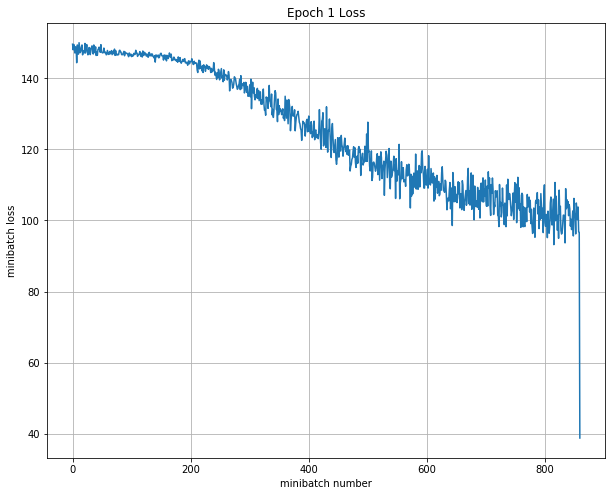

Iteration 1000: with minibatch training loss = 1.32 and accuracy of 0.67
Epoch 2, Overall loss = 1.39 and accuracy of 0.573
cross-validation
Epoch 1, Overall loss = 1.24 and accuracy of 0.653


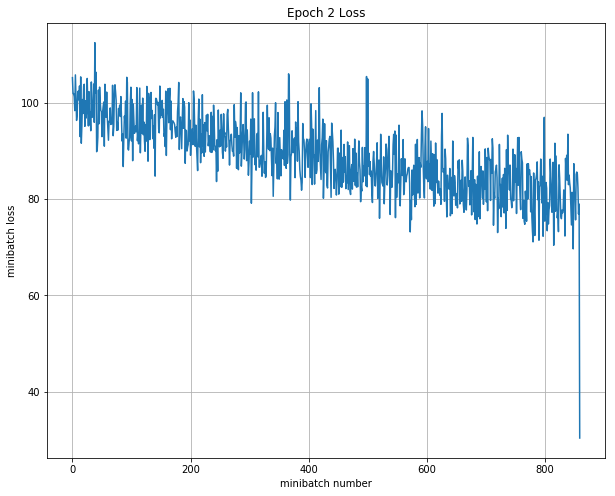

Iteration 2000: with minibatch training loss = 1.12 and accuracy of 0.69
Epoch 3, Overall loss = 1.16 and accuracy of 0.673
cross-validation
Epoch 1, Overall loss = 1.06 and accuracy of 0.724


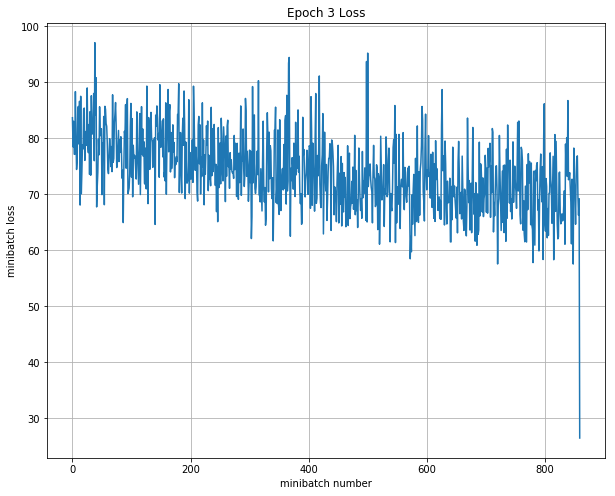

Iteration 3000: with minibatch training loss = 0.932 and accuracy of 0.81
Epoch 4, Overall loss = 1.02 and accuracy of 0.732
cross-validation
Epoch 1, Overall loss = 0.95 and accuracy of 0.782


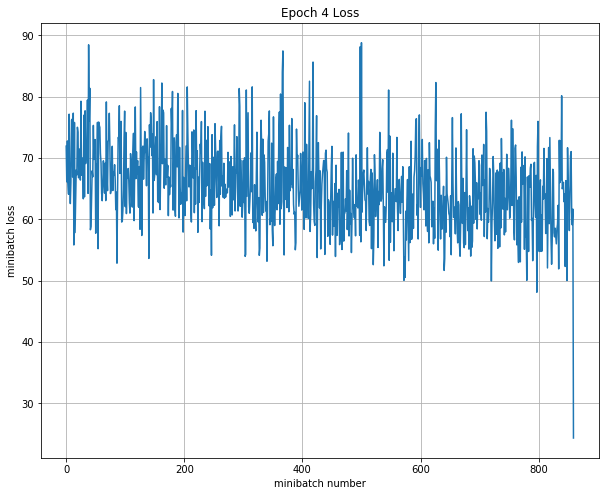

Iteration 4000: with minibatch training loss = 1.02 and accuracy of 0.73
Epoch 5, Overall loss = 0.916 and accuracy of 0.798
cross-validation
Epoch 1, Overall loss = 0.857 and accuracy of 0.827


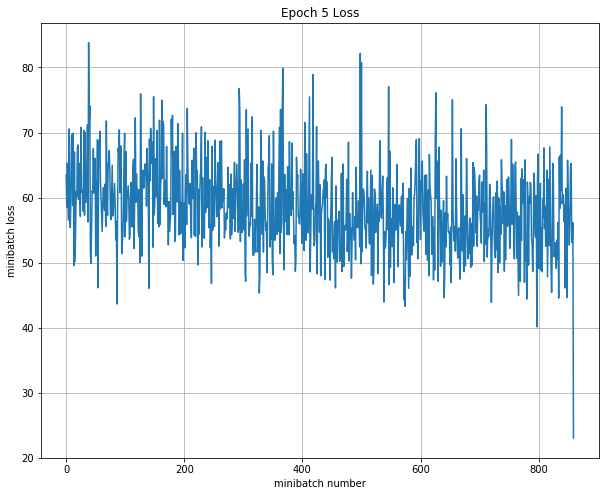

Iteration 5000: with minibatch training loss = 0.942 and accuracy of 0.78
Epoch 6, Overall loss = 0.842 and accuracy of 0.829
cross-validation
Epoch 1, Overall loss = 0.807 and accuracy of 0.84


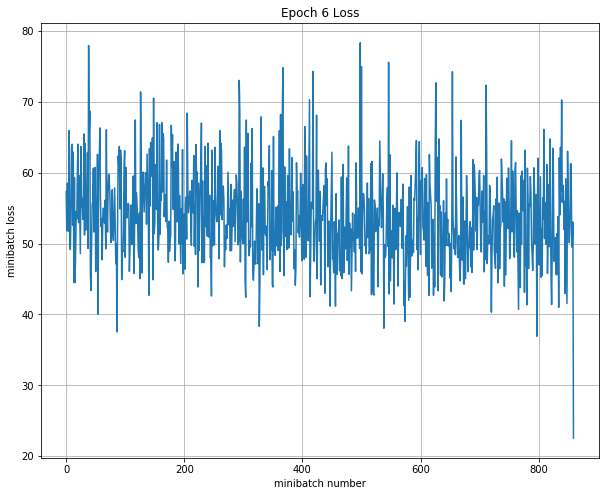

Iteration 6000: with minibatch training loss = 0.847 and accuracy of 0.81
Epoch 7, Overall loss = 0.803 and accuracy of 0.838
cross-validation
Epoch 1, Overall loss = 0.778 and accuracy of 0.846


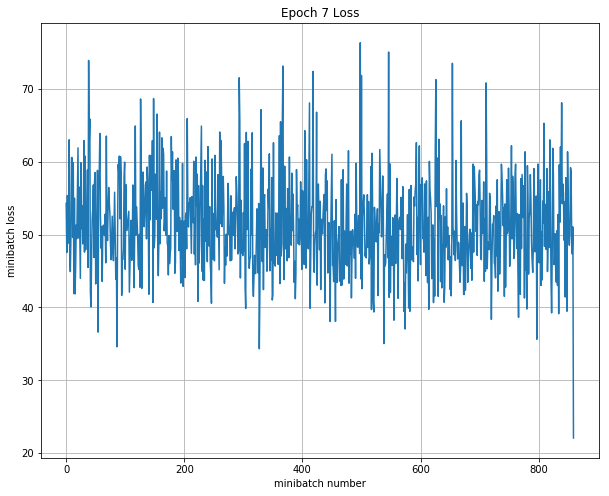

Epoch 8, Overall loss = 0.78 and accuracy of 0.845
cross-validation
Epoch 1, Overall loss = 0.76 and accuracy of 0.852


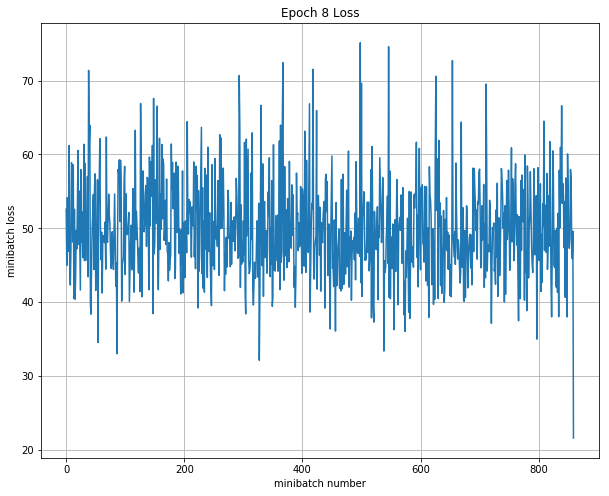

Iteration 7000: with minibatch training loss = 0.763 and accuracy of 0.83
Epoch 9, Overall loss = 0.764 and accuracy of 0.85
cross-validation
Epoch 1, Overall loss = 0.747 and accuracy of 0.857


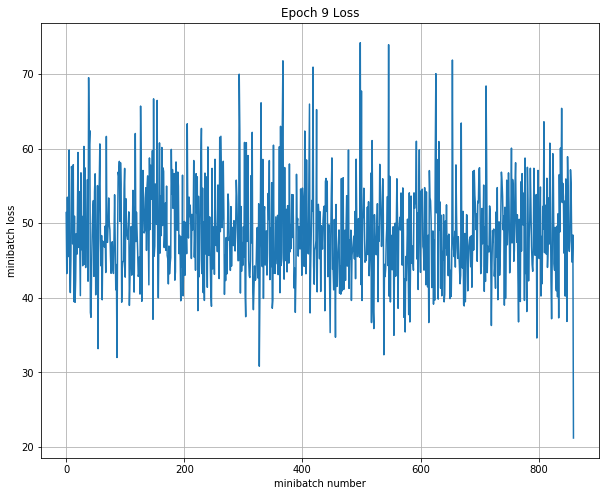

Iteration 8000: with minibatch training loss = 0.947 and accuracy of 0.8
Epoch 10, Overall loss = 0.752 and accuracy of 0.855
cross-validation
Epoch 1, Overall loss = 0.736 and accuracy of 0.861


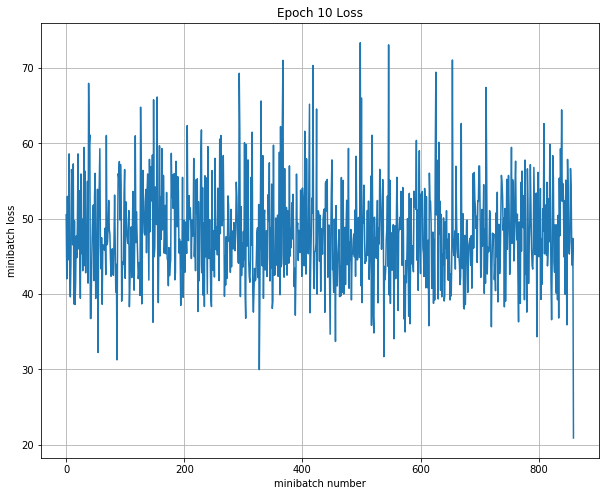

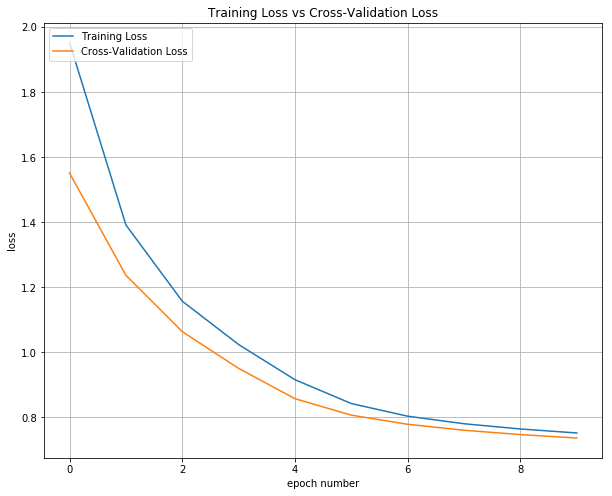

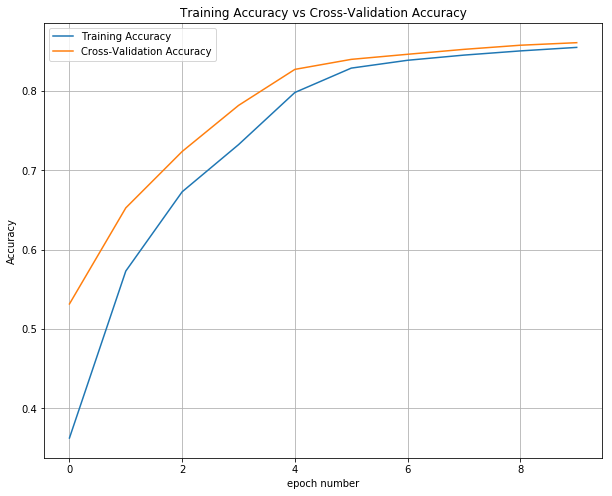

Test
Epoch 1, Overall loss = 0.726 and accuracy of 0.868


In [46]:
sess = tf.Session()
with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,10,64,1000,train_step,True)
    print('Test')
    run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

In [47]:
def normalize(a):
    a_min = np.min(a)
    a_max = np.max(a)
    return (a-a_min)/(a_max - a_min + 1e-8)

Hidden layer weights: 1
Hidden layer weights: 2
out layer weights


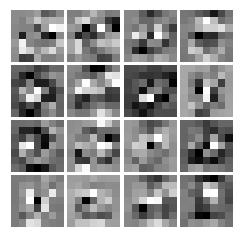

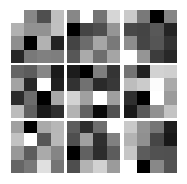

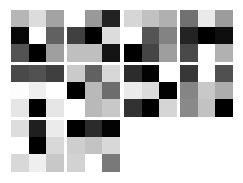

In [48]:
print("Hidden layer weights: 1")
h1_weights = [v for v in tf.trainable_variables() if v.name == "h1_weights:0"][0]
h1_weights_nd = h1_weights.eval(sess).T
show_images(normalize(h1_weights_nd))

print("Hidden layer weights: 2")
h2_weights = [v for v in tf.trainable_variables() if v.name == "h2_weights:0"][0]
h2_weights_nd = h2_weights.eval(sess).T
show_images(normalize(h2_weights_nd))

print("out layer weights")
weights = [v for v in tf.trainable_variables() if v.name == "out_weights:0"][0]
weights_nd = weights.eval(sess).T
show_images(normalize(weights_nd))

(1, 49)


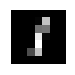

In [50]:
ones_index = (y_test == 1).nonzero()[0]
print(np.shape(X_test[ones_index[0]].reshape(1,D)))
show_images(X_test[ones_index[0]].reshape(1,D))
one_img = X_test[ones_index[0]].reshape(1,D)

In [51]:
def get_probability(scores, target_y):
    e_s = np.exp(scores)
    e_s_sum = np.sum(e_s)
    return e_s[0,target_y]/e_s_sum

def make_fooling_image(X_img, target_y, num_iters=100, learning_rate=1, print_every=10):
    fimagesL = []
    X_fooling = X_img.copy()
    grads = tf.gradients(mean_loss, X)
    prob_target_y = 0
    for i in range(num_iters):
        fimagesL.append(X_fooling.copy())
        s = sess.run(y_out, {X: X_fooling})
        prob_target_y = get_probability(s, target_y)
        if s[0].argmax() == target_y and prob_target_y > 0.9999:
            print("Iteration ", i)
            break
        g = sess.run(grads, {X: X_fooling, y: np.array([target_y])})
        dX = learning_rate * g[0] / tf.norm(g[0])
        dX_val = -1 * dX.eval(session=sess)
        
        if print_every and i % print_every == 0:
            show_images(X_fooling)
            #show_images(dX_val)
            print("Probability of ", target_y, " is ", prob_target_y)
        X_fooling += dX_val
    print("Probability of ", target_y, " is ", prob_target_y)
    return X_fooling, fimagesL

Probability of  2  is  0.952534


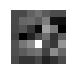

In [52]:
one_fooling_img, fimagesL = make_fooling_image(X_img=one_img, target_y=2, num_iters=100, learning_rate=0.1, print_every=None)
show_images(one_fooling_img)

Probability of  5  is  0.025793
Probability of  5  is  0.916658
Probability of  5  is  0.927882
Probability of  5  is  0.930118
Probability of  5  is  0.931325
Probability of  5  is  0.932325
Probability of  5  is  0.93318
Probability of  5  is  0.933821
Probability of  5  is  0.934301
Probability of  5  is  0.934667
Probability of  5  is  0.934983


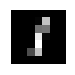

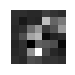

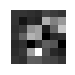

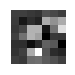

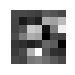

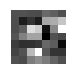

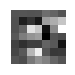

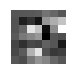

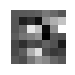

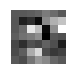

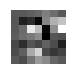

In [53]:
one_fooling_img, fimagesL = make_fooling_image(X_img=one_img, target_y=5, num_iters=100, learning_rate=0.1, print_every=10)
show_images(one_fooling_img)

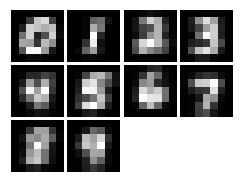

In [54]:
avg_images = np.zeros((10,D))
for i in range(10):
    indices = (y_train == i).nonzero()[0]
    avg_images[i] = np.mean(X_train[indices], axis=0)
    #print(np.shape(X_train[indices]))
    #show_images(mnist.train.images[indices][0:4])
show_images(avg_images)

In [55]:
num_digits = 4
m = int((num_digits)*(num_digits-1))
fimages = np.zeros((m,10,D))
count = 0
for i in range(num_digits):
    for j in range(num_digits):
        if i == j :
            continue
        print("started ", i, ",", j)
        indices = (y_test == i).nonzero()[0]
        digit_img = X_test[indices[0]].reshape(1,D)
        fooling_img, fimagesL = make_fooling_image(X_img=digit_img, target_y=j, num_iters=100, learning_rate=0.1, print_every=None)
        step_size = len(fimagesL)/10
        for c in range(10):
            ind = int(step_size*c)
            fimages[count, c] = fimagesL[ind][0]
            #show_images(fimagesL[ind])
        count+=1
print("Done")

started  0 , 1
Probability of  1  is  0.981446
started  0 , 2
Probability of  2  is  0.951538
started  0 , 3
Probability of  3  is  0.963314
started  1 , 0
Probability of  0  is  0.963676
started  1 , 2
Probability of  2  is  0.952534
started  1 , 3
Probability of  3  is  0.963331
started  2 , 0
Probability of  0  is  0.963697
started  2 , 1
Probability of  1  is  0.981477
started  2 , 3
Probability of  3  is  0.963371
started  3 , 0
Probability of  0  is  0.96366
started  3 , 1
Probability of  1  is  0.981467
started  3 , 2
Probability of  2  is  0.953869
Done


(12, 10, 49)


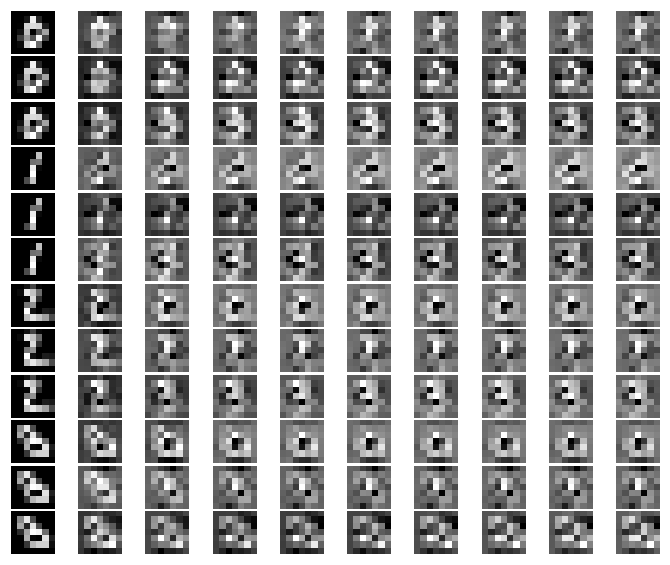

In [56]:
print(np.shape(fimages))
show_images_mxn(fimages, m, 10)